In [1]:
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setup duckdb connection
DB_PATH = '../data/db/master.db'
con = duckdb.connect(DB_PATH)

In [3]:
# phhs data is split into 3 tables 
con.sql('show tables;').show()

┌─────────┐
│  name   │
│ varchar │
├─────────┤
│ actions │
│ hands   │
│ players │
└─────────┘



In [4]:
# `hands` contains a row of all the scalar fields from each parsed hand
con.sql('select * from hands limit 5;').show()

┌────────────┬─────────┬─────────┬─────────────┬─────────────┬────────────────┬─────────────┬─────────────┐
│  hand_id   │ variant │ min_bet │ num_players │ num_actions │     venue      │    table    │ is_showdown │
│   int64    │ varchar │ double  │    int64    │    int64    │    varchar     │   varchar   │   boolean   │
├────────────┼─────────┼─────────┼─────────────┼─────────────┼────────────────┼─────────────┼─────────────┤
│ 3031782172 │ NT      │     6.0 │           5 │           9 │ Absolute Poker │ GUMWOOD AVE │ false       │
│ 3031782562 │ NT      │     6.0 │           5 │           9 │ Absolute Poker │ GUMWOOD AVE │ false       │
│ 3031782958 │ NT      │     6.0 │           5 │          10 │ Absolute Poker │ GUMWOOD AVE │ false       │
│ 3031783810 │ NT      │     6.0 │           5 │          10 │ Absolute Poker │ GUMWOOD AVE │ false       │
│ 3031784372 │ NT      │     6.0 │           5 │          26 │ Absolute Poker │ GUMWOOD AVE │ true        │
└────────────┴─────────┴────

In [5]:
# `players` contains a row for each player in each hand, containing information specific to each player
con.sql('select * from players where hand_id = 3031784372;').show()

┌────────────┬────────┬───────────────────┬────────────────────────┬────────────┬────────────────┬─────────┬────────────┐
│  hand_id   │  ante  │ blind_or_straddle │          name          │ player_idx │ starting_stack │ payoff  │ hole_cards │
│   int64    │ double │      double       │        varchar         │   int64    │     double     │ double  │  varchar   │
├────────────┼────────┼───────────────────┼────────────────────────┼────────────┼────────────────┼─────────┼────────────┤
│ 3031784372 │    0.0 │               3.0 │ dYzGQlQYQnkJl0uVsvJJIg │          1 │         1318.3 │   -21.0 │ NULL       │
│ 3031784372 │    0.0 │               6.0 │ sSZBJzpy1ZH4aGvCJdw9qw │          2 │         1307.4 │   -21.0 │ NULL       │
│ 3031784372 │    0.0 │               0.0 │ QE2Vn7Qn2j+IUR+rOKncTA │          3 │         2086.9 │     0.0 │ NULL       │
│ 3031784372 │    0.0 │               0.0 │ 8z33KASCGgAHVfxu6HD4UA │          4 │         755.25 │  797.25 │ KsTc       │
│ 3031784372 │    0.0 │ 

In [6]:
# Note that this table is not a list of all players.
# Rather, it stores player-specific information for each hand.
# To illustrate this, we can query from this table all the hands that the player `dYzGQlQYQnkJl0uVsvJJIg` participated in:
con.sql("select distinct hand_id from players where name = 'dYzGQlQYQnkJl0uVsvJJIg';")

┌────────────┐
│  hand_id   │
│   int64    │
├────────────┤
│ 3029729864 │
│ 3029736712 │
│ 3029860306 │
│ 3029910782 │
│ 3029917908 │
│ 3029973018 │
│ 3029531148 │
│ 3029552754 │
│ 3029576326 │
│ 3029671142 │
│      ·     │
│      ·     │
│      ·     │
│ 3024666200 │
│ 3017890202 │
│ 3017897680 │
│ 3017935430 │
│ 3017938262 │
│ 3017942604 │
│ 3017948994 │
│ 3017951118 │
│ 3017979648 │
│ 3017980198 │
├────────────┤
│ 1657 rows  │
│ (20 shown) │
└────────────┘

In [7]:
# `actions` contains a row for each action in each hand
con.sql('select * from actions where hand_id = 3031784372;').show()

┌────────────┬──────────────┬─────────┬─────────────┬────────┬──────────────────┬─────────────┬─────────┬──────────────┐
│  hand_id   │ action_index │  actor  │ action_type │ amount │ total_pot_amount │ is_terminal │  cards  │  raw_action  │
│   int64    │    int64     │ varchar │   varchar   │ double │      double      │   boolean   │ varchar │   varchar    │
├────────────┼──────────────┼─────────┼─────────────┼────────┼──────────────────┼─────────────┼─────────┼──────────────┤
│ 3031784372 │            1 │ d       │ dh          │   NULL │              9.0 │ false       │ p1 ???? │ d dh p1 ???? │
│ 3031784372 │            2 │ d       │ dh          │   NULL │              9.0 │ false       │ p2 ???? │ d dh p2 ???? │
│ 3031784372 │            3 │ d       │ dh          │   NULL │              9.0 │ false       │ p3 ???? │ d dh p3 ???? │
│ 3031784372 │            4 │ d       │ dh          │   NULL │              9.0 │ false       │ p4 ???? │ d dh p4 ???? │
│ 3031784372 │            5 │ d 

In [8]:
# Okay, enough with the basics. Let's answer some questions.
# Q1: Who are the most active players on the site?

query = '''
select
    p.name,
    count(*) as cnt
from players p join hands h on p.hand_id = h.hand_id
group by p.name
order by cnt desc
limit 5;
'''

con.sql(query).show()

┌────────────────────────┬───────┐
│          name          │  cnt  │
│        varchar         │ int64 │
├────────────────────────┼───────┤
│ HQg4dAYPUt6c2wXfx8Qp2A │ 31394 │
│ /P+7Z0P/b7YiK60FW9dRAQ │ 22034 │
│ 9kGpt+XUpavowCzDUv23cw │ 22002 │
│ igvhUfnIs8in/SlI6b2cug │ 21149 │
│ 3EA9QYFUt9qtTlUYPg56jw │ 20961 │
└────────────────────────┴───────┘



In [9]:
# Q2: What does the distribution of hand lengths look like?

query = '''
select
    num_actions,
    count(*) as cnt
from hands
group by num_actions
'''

num_actions_df = con.sql(query).df()
num_actions_df.head()

,num_actions,cnt
0,3,74357
1,4,69277
2,5,18928
3,6,7581
4,7,25844


<Axes: xlabel='num_actions', ylabel='cnt'>

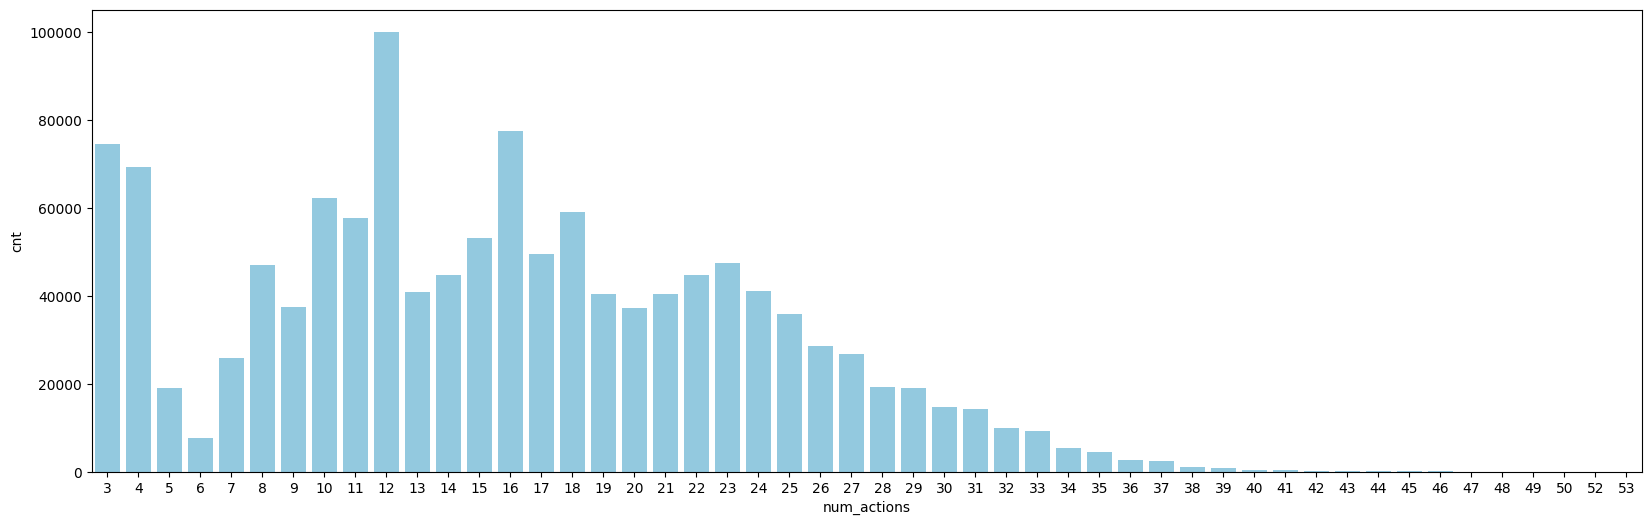

In [10]:
plt.figure(figsize=(20,6))
sns.barplot(x='num_actions', y='cnt', data=num_actions_df, color='skyblue')

In [11]:
# Q3: What does the distribution of VPIP's look like?

query = '''
with flop_index as (
    select hand_id, min(action_index) as flop_action_index
    from actions
    where action_type = 'db' and length(cards) = 6
    group by hand_id
),

preflop_actions as (
    select
        a.hand_id,
        p.name as player_name,
        coalesce(a.amount, 0) as amount,
        coalesce(p.blind_or_straddle, 0) as blind_or_straddle
    from actions a
    join players p
      on a.hand_id = p.hand_id and a.actor = 'p' || cast(p.player_idx as varchar)
    left join flop_index f
      on a.hand_id = f.hand_id
    where a.action_index < coalesce(f.flop_action_index, -1)
),

vpip as (
    select
        hand_id,
        player_name,
        case when sum(case when amount > blind_or_straddle then 1 else 0 end) > 0
             then 1 else 0 end as vpip
    from preflop_actions
    group by hand_id, player_name
)

select
    player_name,
    avg(coalesce(vpip, 0)) as vpip,
    count(distinct hand_id) as sample_size
from vpip
group by player_name
having sample_size >= 200
order by random();
'''

df_vpip = con.sql(query).df()
df_vpip.head()

,player_name,vpip,sample_size
0,Jt2NLQSv5gW/r/9T3PNsRQ,0.088591,2235
1,2rmHbthZ159g3a9Y4AK2hg,0.144189,3003
2,Zy+Q3ZfhvhIO3VdiC2b4Mg,0.036530,219
3,Y+IP7fheX4Y38yuBMX1HOA,0.084577,201
4,H9ZeZX6+QzbliXmP/NEGEQ,0.098253,458


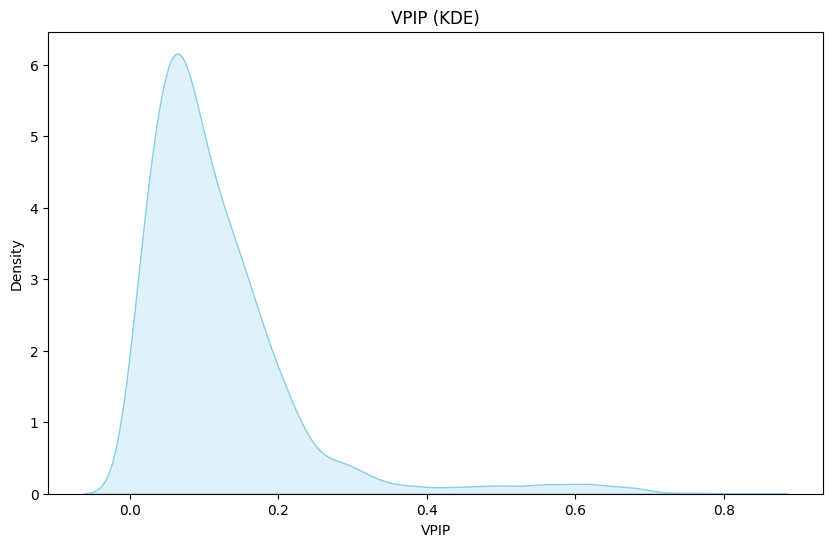

In [12]:
plt.figure(figsize=(10,6))
sns.kdeplot(df_vpip['vpip'], fill=True, color='skyblue')
plt.title('VPIP (KDE)')
plt.xlabel('VPIP')
plt.ylabel('Density')
plt.show()

In [13]:
con.close()